In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
from google.colab import userdata
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Optional
from transformers import AutoTokenizer
import re
from datetime import datetime
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from collections import Counter, defaultdict
import random
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import json
import math
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
import catboost
from sklearn.ensemble import VotingRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
CHUNK_SIZE = 1000
MIN_PRICE = 0.5
MAX_PRICE = 999.49

class ItemLoader:


    def __init__(self, name):
        self.name = name
        self.dataset = None

    def from_datapoint(self, datapoint):

        try:
            price_str = datapoint['price']
            if price_str:
                price = float(price_str)
                if MIN_PRICE <= price <= MAX_PRICE:
                    item = Item(datapoint, price)
                    return item if item.include else None
        except ValueError:
            return None

    def from_chunk(self, chunk):

        batch = []
        for datapoint in chunk:
            result = self.from_datapoint(datapoint)
            if result:
                batch.append(result)
        return batch

    def chunk_generator(self):

        size = len(self.dataset)
        for i in range(0, size, CHUNK_SIZE):
            yield self.dataset.select(range(i, min(i + CHUNK_SIZE, size)))

    def load_in_parallel(self, workers):

        results = []
        chunk_count = (len(self.dataset) // CHUNK_SIZE) + 1
        with ProcessPoolExecutor(max_workers=workers) as pool:
            for batch in tqdm(pool.map(self.from_chunk, self.chunk_generator()), total=chunk_count):
                results.extend(batch)
        for result in results:
            result.category = self.name
        return results

    def load(self, workers=8):

        start = datetime.now()
        print(f"Loading dataset {self.name}", flush=True)
        self.dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{self.name}", split="full", trust_remote_code=True)
        results = self.load_in_parallel(workers)
        finish = datetime.now()
        print(f"Completed {self.name} with {len(results):,} datapoints in {(finish-start).total_seconds()/60:.1f} mins", flush=True)
        return results

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
MIN_TOKENS = 150
MAX_TOKENS = 160
MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

class Item:

    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
    PREFIX = "Price is $"
    QUESTION = "How much does this cost to the nearest dollar?"
    REMOVALS = ['"Batteries Included?": "No"', '"Batteries Included?": "Yes"', '"Batteries Required?": "No"', '"Batteries Required?": "Yes"', "By Manufacturer", "Item", "Date First", "Package", ":", "Number of", "Best Sellers", "Number", "Product "]

    title: str
    price: float
    category: str
    token_count: int = 0
    details: Optional[str]
    prompt: Optional[str] = None
    include = False

    def __init__(self, data, price):
        self.title = data['title']
        self.price = price
        self.parse(data)

    def scrub_details(self):

        details = self.details
        for remove in self.REMOVALS:
            details = details.replace(remove, "")
        return details

    def scrub(self, stuff):

        stuff = re.sub(r'[:\[\]"{}【】\s]+', ' ', stuff).strip()
        stuff = stuff.replace(" ,", ",").replace(",,,",",").replace(",,",",")
        words = stuff.split(' ')
        select = [word for word in words if len(word)<7 or not any(char.isdigit() for char in word)]
        return " ".join(select)

    def parse(self, data):

        contents = '\n'.join(data['description'])
        if contents:
            contents += '\n'
        features = '\n'.join(data['features'])
        if features:
            contents += features + '\n'
        self.details = data['details']
        if self.details:
            contents += self.scrub_details() + '\n'
        if len(contents) > MIN_CHARS:
            contents = contents[:CEILING_CHARS]
            text = f"{self.scrub(self.title)}\n{self.scrub(contents)}"
            tokens = self.tokenizer.encode(text, add_special_tokens=False)
            if len(tokens) > MIN_TOKENS:
                tokens = tokens[:MAX_TOKENS]
                text = self.tokenizer.decode(tokens)
                self.make_prompt(text)
                self.include = True

    def make_prompt(self, text):

        self.prompt = f"{self.QUESTION}\n\n{text}\n\n"
        self.prompt += f"{self.PREFIX}{str(round(self.price))}.00"
        self.token_count = len(self.tokenizer.encode(self.prompt, add_special_tokens=False))

    def test_prompt(self):

        return self.prompt.split(self.PREFIX)[0] + self.PREFIX

    def __repr__(self):

        return f"<{self.title} = ${self.price}>"

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [ ]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [ ]:
with open('train_mini.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_mini.pkl', 'rb') as file:
    test = pickle.load(file)

In [ ]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Wagner Brake Disc Brake Rotor
Wagner® premium brake rotors are engineered with technology focused on providing maximum performance, corrosion resistance and ease of installation. Pair Wagner rotors with Wagner brake pads for optimal performance. ENGINEERED FOR PERFORMANCE -- OE-specific vane design provides effective braking power and heat dissipation while controlling noise, vibration and harshness PREMIUM PROTECTION -- E-Shield protective coating is applied to non-braking surfaces to inhibit corrosion TURNED AND SMOOTH FINISH -- Requires less pad break-in time and aids in proper bedding EASY INSTALLATION -- Rotors are packaged in a Vapor Corrosion Inhibitor bag, eliminating the need for an oil coating which reduces prep time PROPER BALANCE -- Spin balanced and cut to limit vibration for improving stability and control PERF

Price is $65.00


In [ ]:
print(train[0].price)

65.43


In [ ]:
test

[<Lund 383022-B Catch-It Vinyl Black Rear Seat Floor Mat = $69.25>,
 <MZORANGE Tail Light Lamp Stop Brake Indicator Warning Light For Land Rover Range Rover L405 2013 2014 2015 2016 2017 with Bulb (Right Passenger Side) = $189.99>,
 <X AUTOHAUX Rear Tailgate Latch Hatch Liftgate Actuator 81230-1W010 812301W010 81230-1W000 for Kia Rio 2011-2017 = $17.19>,
 <PGTOPONE Red LED Rear Bumper Reflectors Fog Brake Tail Light Lamps Turn Signal Light Plug and play Kit for Tesla Model Y 2021 2022 Accessories (Red, Model Y) = $48.88>,
 <Front Bumper for THE HARDBODY CRAWLER CO FJ Series = $27.99>,
 <Detroit Axle - 12.64" Front Drilled & Slotted Rotors Ceramic Pads Replacement for Buick LaCrosse Regal Chevy Impala Malibu Equinox GMC Terrain - 4pc Set = $143.27>,
 <NUVISION LIGHTING 3BL-ZTL-001-CH Super Bright LED 2-Stage Sequential Third Tail Brake Light Clear Lens Compatible with 04-08 F-150 = $64.79>,
 <EBC S5KF1444 Stage-5 Superstreet Brake Kit, BLACK = $231.93>,
 <Car Console Covers Plus Made in

In [ ]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [ ]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
X_transformer = np.array([model.encode(doc) for doc in documents])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
xgbgressor = XGBRegressor(n_estimators=100, random_state=42, n_jobs=8)
xgbgressor.fit(X_transformer, prices)

In [ ]:
def xgb_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = model.encode(doc)
    return max(float(xgbgressor.predict([doc_vector])[0]), 0)

1: Guess: $109.29 Truth: $69.25 Error: $40.04 SLE: 0.20 Item: Lund 383022-B Catch-It Vinyl Black Rear ...
2: Guess: $71.03 Truth: $189.99 Error: $118.96 SLE: 0.95 Item: MZORANGE Tail Light Lamp Stop Brake Indi...
3: Guess: $22.51 Truth: $17.19 Error: $5.32 SLE: 0.07 Item: X AUTOHAUX Rear Tailgate Latch Hatch Lif...
4: Guess: $19.00 Truth: $48.88 Error: $29.88 SLE: 0.83 Item: PGTOPONE Red LED Rear Bumper Reflectors ...
5: Guess: $88.75 Truth: $27.99 Error: $60.76 SLE: 1.28 Item: Front Bumper for THE HARDBODY CRAWLER CO...
6: Guess: $131.65 Truth: $143.27 Error: $11.62 SLE: 0.01 Item: Detroit Axle - 12.64" Front Drilled & Sl...
7: Guess: $61.14 Truth: $64.79 Error: $3.65 SLE: 0.00 Item: NUVISION LIGHTING 3BL-ZTL-001-CH Super B...
8: Guess: $133.50 Truth: $231.93 Error: $98.43 SLE: 0.30 Item: EBC S5KF1444 Stage-5 Superstreet Brake K...
9: Guess: $64.36 Truth: $29.95 Error: $34.41 SLE: 0.56 Item: Car Console Covers Plus Made in USA Faux...
10: Guess: $75.26 Truth: $139.99 Error: $64.73 SLE

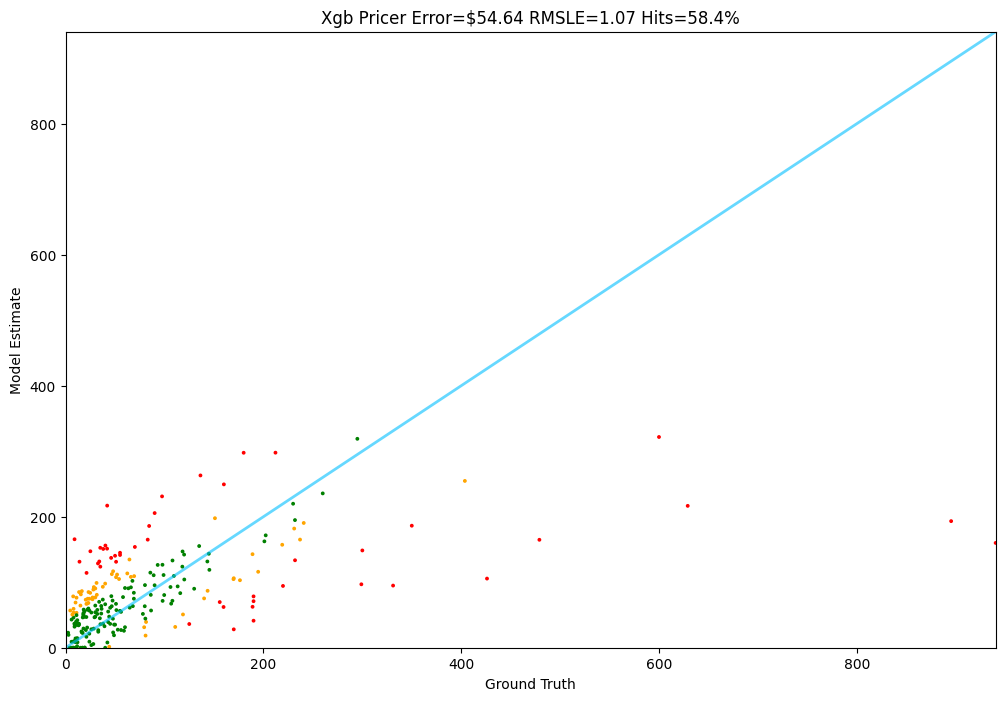

In [ ]:
Tester.test(xgb_pricer)

In [ ]:
import joblib

joblib.dump(xgbgressor, 'xgb_model.pkl')

['xgb_model.pkl']

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_transformer, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [ ]:
def random_forest_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = model.encode(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $103.35 Truth: $69.25 Error: $34.10 SLE: 0.16 Item: Lund 383022-B Catch-It Vinyl Black Rear ...
2: Guess: $52.16 Truth: $189.99 Error: $137.83 SLE: 1.64 Item: MZORANGE Tail Light Lamp Stop Brake Indi...
3: Guess: $60.77 Truth: $17.19 Error: $43.58 SLE: 1.49 Item: X AUTOHAUX Rear Tailgate Latch Hatch Lif...
4: Guess: $53.28 Truth: $48.88 Error: $4.40 SLE: 0.01 Item: PGTOPONE Red LED Rear Bumper Reflectors ...
5: Guess: $90.92 Truth: $27.99 Error: $62.93 SLE: 1.33 Item: Front Bumper for THE HARDBODY CRAWLER CO...
6: Guess: $139.75 Truth: $143.27 Error: $3.52 SLE: 0.00 Item: Detroit Axle - 12.64" Front Drilled & Sl...
7: Guess: $84.10 Truth: $64.79 Error: $19.31 SLE: 0.07 Item: NUVISION LIGHTING 3BL-ZTL-001-CH Super B...
8: Guess: $120.34 Truth: $231.93 Error: $111.59 SLE: 0.43 Item: EBC S5KF1444 Stage-5 Superstreet Brake K...
9: Guess: $56.68 Truth: $29.95 Error: $26.73 SLE: 0.39 Item: Car Console Covers Plus Made in USA Faux...
10: Guess: $63.81 Truth: $139.99 Error: $76.18 SL

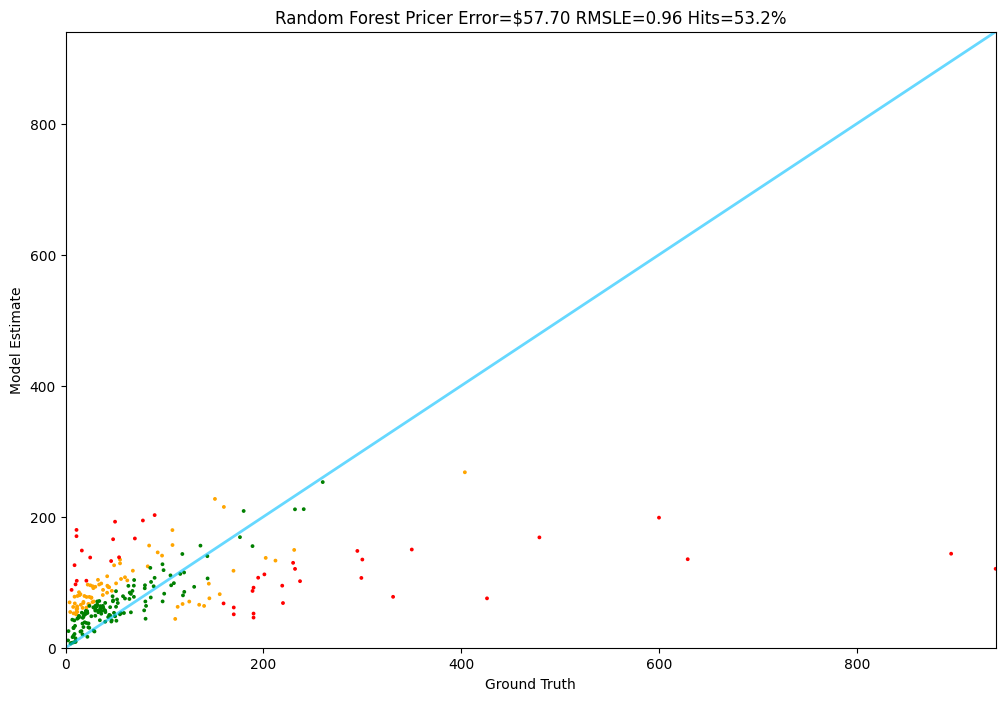

In [ ]:
Tester.test(random_forest_pricer)

In [ ]:
import joblib

joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [ ]:
documents[0]

'How much does this cost to the nearest dollar?\n\nWagner Brake Disc Brake Rotor\nWagner® premium brake rotors are engineered with technology focused on providing maximum performance, corrosion resistance and ease of installation. Pair Wagner rotors with Wagner brake pads for optimal performance. ENGINEERED FOR PERFORMANCE -- OE-specific vane design provides effective braking power and heat dissipation while controlling noise, vibration and harshness PREMIUM PROTECTION -- E-Shield protective coating is applied to non-braking surfaces to inhibit corrosion TURNED AND SMOOTH FINISH -- Requires less pad break-in time and aids in proper bedding EASY INSTALLATION -- Rotors are packaged in a Vapor Corrosion Inhibitor bag, eliminating the need for an oil coating which reduces prep time PROPER BALANCE -- Spin balanced and cut to limit vibration for improving stability and control PERF\n\nPrice is $'

In [ ]:
lgbm_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=8)
lgbm_model.fit(X_transformer, prices)

In [ ]:
def lightgbm_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = model.encode(doc)
    return max(0, lgbm_model.predict([doc_vector])[0])

1: Guess: $94.25 Truth: $69.25 Error: $25.00 SLE: 0.09 Item: Lund 383022-B Catch-It Vinyl Black Rear ...
2: Guess: $74.89 Truth: $189.99 Error: $115.10 SLE: 0.85 Item: MZORANGE Tail Light Lamp Stop Brake Indi...
3: Guess: $36.06 Truth: $17.19 Error: $18.87 SLE: 0.51 Item: X AUTOHAUX Rear Tailgate Latch Hatch Lif...
4: Guess: $50.59 Truth: $48.88 Error: $1.71 SLE: 0.00 Item: PGTOPONE Red LED Rear Bumper Reflectors ...
5: Guess: $84.95 Truth: $27.99 Error: $56.96 SLE: 1.18 Item: Front Bumper for THE HARDBODY CRAWLER CO...
6: Guess: $154.26 Truth: $143.27 Error: $10.99 SLE: 0.01 Item: Detroit Axle - 12.64" Front Drilled & Sl...
7: Guess: $78.88 Truth: $64.79 Error: $14.09 SLE: 0.04 Item: NUVISION LIGHTING 3BL-ZTL-001-CH Super B...
8: Guess: $171.53 Truth: $231.93 Error: $60.40 SLE: 0.09 Item: EBC S5KF1444 Stage-5 Superstreet Brake K...
9: Guess: $81.30 Truth: $29.95 Error: $51.35 SLE: 0.96 Item: Car Console Covers Plus Made in USA Faux...
10: Guess: $41.79 Truth: $139.99 Error: $98.20 SLE

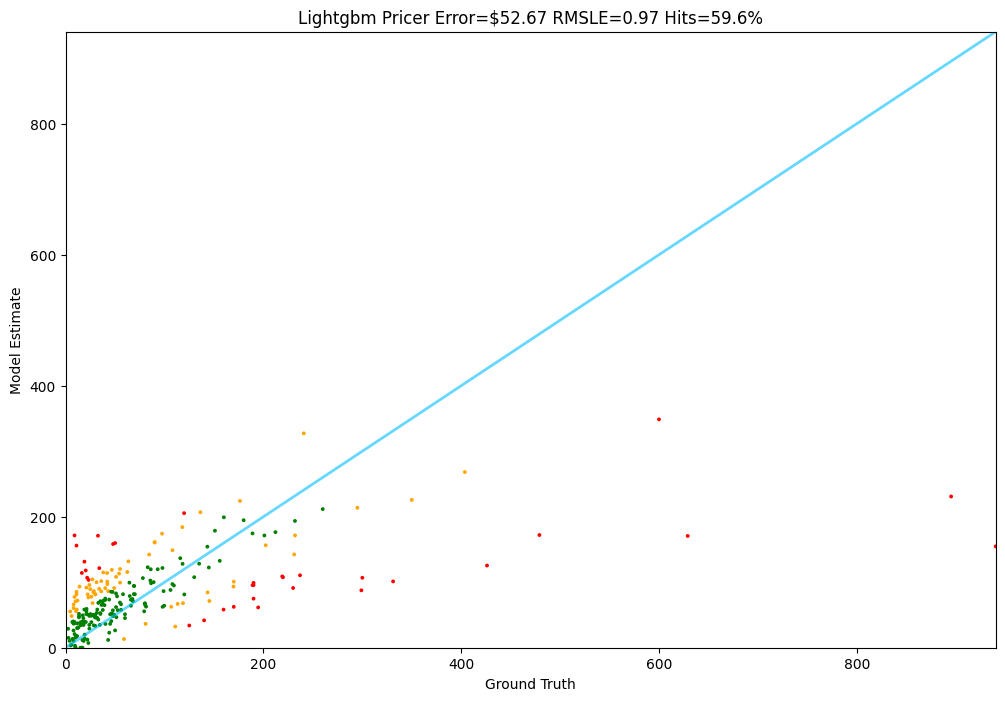

In [ ]:
Tester.test(lightgbm_pricer)

In [ ]:
import joblib

joblib.dump(lgbm_model, 'lgbm_model.pkl')

['lgbm_model.pkl']

In [ ]:
cat_model = catboost.CatBoostRegressor(n_estimators=100, random_state=42, thread_count=8)
cat_model.fit(X_transformer, prices)

Learning rate set to 0.442643
0:	learn: 103.9280935	total: 79ms	remaining: 7.82s
1:	learn: 101.7389089	total: 103ms	remaining: 5.07s
2:	learn: 99.8872160	total: 127ms	remaining: 4.12s
3:	learn: 98.7105539	total: 151ms	remaining: 3.61s
4:	learn: 97.5313332	total: 174ms	remaining: 3.31s
5:	learn: 96.6001547	total: 197ms	remaining: 3.09s
6:	learn: 95.5012801	total: 221ms	remaining: 2.94s
7:	learn: 94.7604709	total: 244ms	remaining: 2.8s
8:	learn: 94.0600565	total: 268ms	remaining: 2.71s
9:	learn: 93.4982142	total: 290ms	remaining: 2.61s
10:	learn: 93.0092345	total: 312ms	remaining: 2.52s
11:	learn: 92.3368425	total: 337ms	remaining: 2.47s
12:	learn: 91.8932430	total: 361ms	remaining: 2.42s
13:	learn: 91.2516358	total: 385ms	remaining: 2.37s
14:	learn: 90.8845469	total: 410ms	remaining: 2.32s
15:	learn: 90.5634250	total: 432ms	remaining: 2.27s
16:	learn: 90.1844353	total: 455ms	remaining: 2.22s
17:	learn: 89.7158310	total: 479ms	remaining: 2.18s
18:	learn: 89.2345831	total: 503ms	remaining

In [ ]:
def cat_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = model.encode(doc)
    return max(0, cat_model.predict([doc_vector])[0])

1: Guess: $96.27 Truth: $69.25 Error: $27.02 SLE: 0.11 Item: Lund 383022-B Catch-It Vinyl Black Rear ...
2: Guess: $82.69 Truth: $189.99 Error: $107.30 SLE: 0.68 Item: MZORANGE Tail Light Lamp Stop Brake Indi...
3: Guess: $32.46 Truth: $17.19 Error: $15.27 SLE: 0.37 Item: X AUTOHAUX Rear Tailgate Latch Hatch Lif...
4: Guess: $78.01 Truth: $48.88 Error: $29.13 SLE: 0.21 Item: PGTOPONE Red LED Rear Bumper Reflectors ...
5: Guess: $129.47 Truth: $27.99 Error: $101.48 SLE: 2.26 Item: Front Bumper for THE HARDBODY CRAWLER CO...
6: Guess: $146.50 Truth: $143.27 Error: $3.23 SLE: 0.00 Item: Detroit Axle - 12.64" Front Drilled & Sl...
7: Guess: $91.67 Truth: $64.79 Error: $26.88 SLE: 0.12 Item: NUVISION LIGHTING 3BL-ZTL-001-CH Super B...
8: Guess: $138.58 Truth: $231.93 Error: $93.35 SLE: 0.26 Item: EBC S5KF1444 Stage-5 Superstreet Brake K...
9: Guess: $93.54 Truth: $29.95 Error: $63.59 SLE: 1.25 Item: Car Console Covers Plus Made in USA Faux...
10: Guess: $62.02 Truth: $139.99 Error: $77.97 S

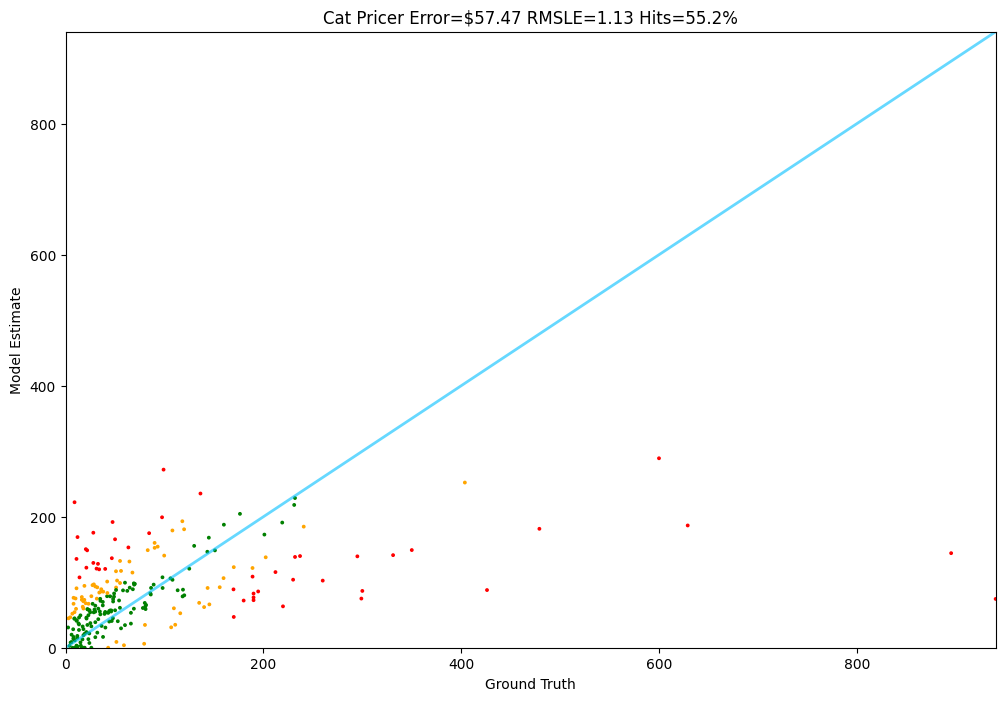

In [ ]:
Tester.test(cat_pricer)

In [ ]:
import joblib

joblib.dump(cat_model, 'cat_model.pkl')

['cat_model.pkl']

In [ ]:
test[0].price

69.25

In [ ]:
import joblib
xgb_model = joblib.load('xgb_model.pkl')

lgbm_model = joblib.load('lgbm_model.pkl')

In [ ]:
lgbm_predicted = []
xgb_predicted = []
min_predicted = []
max_predicted = []
y = []
for i in range(len(test)):
    doc = test[i].prompt
    doc_vector = model.encode(doc)
    lgbm_predicted.append(max(0, lgbm_model.predict([doc_vector])[0]))
    xgb_predicted.append(max(xgb_model.predict([doc_vector])[0], 0))
    min_predicted.append(min(lgbm_predicted[-1], xgb_predicted[-1]))
    max_predicted.append(max(lgbm_predicted[-1], xgb_predicted[-1]))
    y.append(test[i].price)

In [ ]:
X = pd.DataFrame({
  'Specialist': lgbm_predicted,
  'XGBoost': xgb_predicted ,
  'Min': min_predicted,
  'Max': max_predicted,
  })

In [ ]:
li_reg = LinearRegression()
li_reg.fit(X, y)

LinearRegression()

In [ ]:
import joblib

joblib.dump(li_reg, 'ensemble.pkl')

['ensemble.pkl']